# Wikipedia Articles - Finding NNs of articles

### Algorithm:
* NearestNeighbors from sklearn


### Models used:
* Model 1 - Bag of words document representation (euclidean distance)
* Model 2 - TF-IDF document representation (euclidean distance)
* Model 3 - TF-IDF document representation (cosine similarity)

In [1]:
import pandas as pd                     
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices
import json

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

### Loading the data

In [2]:
# data of text
wiki = pd.read_csv("people_wiki.csv")

In [3]:
# word_count_loader
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)



word_count = load_sparse_csr('people_wiki_word_count.npz')  ## 59071x547979

In [4]:
print(wiki.shape)
wiki.head()

(59071, 3)


,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [5]:
print(type(word_count))
print(word_count.shape)
word_count

<class 'scipy.sparse.csr.csr_matrix'>
(59071, 547979)


<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [6]:
# dict mapping indices to words (associated with sparse matrix above (word_count))
with open("people_wiki_map_index_to_word.json") as json_file:
    map_index_to_word = json.load(json_file)  # size = 547979


In [7]:
{k: map_index_to_word[k] for k in list(map_index_to_word)[:5]}

{'biennials': 522004,
 'lb915': 116290,
 'shatzky': 127647,
 'woode': 174106,
 'damfunk': 133206}

# Model 1 - Bag of Words

In [8]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [9]:
print(wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [10]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

In [14]:
print(distances)
print(indices)

[[ 0.         33.07567082 34.39476704 36.15245497 36.16628264 36.33180425
  36.40054945 36.49657518 36.63331817 36.95943723]]
[[35817 24478 28447 35357 14754 13229 31423 22745 36364  9210]]


In [17]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
print(wiki.join(neighbors.set_index('id')).sort_values('distance')[['name','distance']][:10])

                             name   distance
35817                Barack Obama   0.000000
24478                   Joe Biden  33.075671
28447              George W. Bush  34.394767
35357            Lawrence Summers  36.152455
14754                 Mitt Romney  36.166283
13229            Francisco Barrio  36.331804
31423              Walter Mondale  36.400549
22745  Wynn Normington Hugh-Jones  36.496575
36364                  Don Bonker  36.633318
9210                 Andy Anstett  36.959437


In [18]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [19]:
def unpack_dict(matrix, map_index_to_word):
    #table = list(map_index_to_word.sort('index')['category'])
    # if you're not using SFrame, replace this line with
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [20]:
wiki.head()

,URI,name,text,word_count
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '..."


In [46]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    
    word_count_table = pd.DataFrame.from_dict(dict(row['word_count']))
    word_count_table = word_count_table.reset_index()
    word_count_table.columns = ['word', 'count']
    return word_count_table.sort_values('count', ascending=False)

In [47]:
obama_words = top_words('Barack Obama')
print(obama_words)

            word  count
245          the     40
118           in     30
31           and     21
165           of     18
248           to     14
109          his     11
163        obama      9
21           act      8
20             a      7
107           he      7
33            as      6
259           us      6
136          law      6
263          was      5
27         after      4
77    democratic      4
63       control      4
126         iraq      4
182    president      4
94           for      4
149     military      4
105          has      4
268         with      3
242         term      3
177        party      3
93         first      3
220       school      3
226       signed      3
172      ordered      3
129      january      3
..           ...    ...
122  initiatives      1
120     included      1
78      district      1
119  inaugurated      1
79     doddfrank      1
82          down      1
84       earning      1
85      economic      1
87    elementary      1
88         ended

In [48]:
barrio_words = top_words('Francisco Barrio')
print(barrio_words)

             word  count
204           the     36
147            of     24
23            and     18
102            in     17
95             he     10
206            to      9
50      chihuahua      7
90       governor      6
14              a      6
28             as      5
99            his      5
194         state      4
87           from      4
214           was      4
224         years      3
142      national      3
17         action      3
84         former      3
82          first      3
155         party      3
83            for      3
191        served      2
70         during      2
39       becoming      2
40         before      2
41           born      2
58        control      2
46      candidate      2
42             by      2
149           one      2
..            ...    ...
120         local      1
121          lost      1
122          made      1
123         mayor      1
124     mayorship      1
96         headed      1
94            has      1
93        groupon      1


In [49]:
combined_words =  obama_words.join(barrio_words.set_index('word'), on='word',lsuffix='Obama', rsuffix='Barrio',how='inner')
common_words = set(combined_words['word'][:5]) # YOUR CODE HERE
common_words

{'and', 'in', 'of', 'the', 'to'}

In [51]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words) # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

wiki.head()

,URI,name,text,word_count,has_top_words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False


In [52]:
print('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))

Output from your function: True


Pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden.

In [53]:
from sklearn.metrics.pairwise import euclidean_distances

print(euclidean_distances(word_count[35817], word_count[24478]))  # obama # baiden
print(euclidean_distances(word_count[35817], word_count[28447]))  # obama bush
print(euclidean_distances(word_count[24478], word_count[28447])) # baiden bush

[[33.07567082]]
[[34.39476704]]
[[32.75667871]]


# TF-IDF

In [54]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz') # 59071x547979

In [60]:
print(wiki.shape)
print(tf_idf.shape)
print(word_count.shape)

(59071, 5)
(59071, 547979)
(59071, 547979)


* word_count eg {'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1, '44game': 1, 'mckernan': 1, 'morrell': 5 ...

* tf-idf eg {'brisbaneafter': 10.986495389225194, 'edflhe': 10.986495389225194, 'aflfrom': 10.986495389225194, '44game': 9.887883100557085, 'mckernan': 9.600201028105303, 'morrell': 46.88528738395547 ....

In [61]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [62]:
wiki.head()

,URI,name,text,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True,"{'fantasticrottensteiner': 10.986495389225194,..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1..."


### Model 2 - TF-IDF with Euclidean similarity function

In [63]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [64]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
print(wiki.join(neighbors.set_index('id')).sort_values('distance')[['name', 'distance']][:10])

                          name    distance
35817             Barack Obama    0.000000
7914             Phil Schiliro  106.861014
46811            Jeff Sessions  108.871674
44681   Jesse Lee (politician)  109.045698
38376           Samantha Power  109.108106
6507              Bob Menendez  109.781867
38714  Eric Stern (politician)  109.957788
44825           James A. Guest  110.413889
44368     Roland Grossenbacher  110.470609
33417            Tulsi Gabbard  110.696998


In [66]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    
    word_count_table = pd.DataFrame.from_dict(dict(wiki[wiki['name'] == name]['tf_idf']))
    word_count_table = word_count_table.reset_index()
    word_count_table.columns = ['word', 'weight']
    return word_count_table.sort_values('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print(obama_tf_idf)

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')

                word     weight
163            obama  43.295653
21               act  27.678223
126             iraq  17.747379
63           control  14.887061
136              law  14.722936
172          ordered  14.533374
149         military  13.115933
211         response  12.784385
125      involvement  12.784385
77        democratic  12.410689
259               us  11.591943
14         2012obama  10.986495
114            husen  10.986495
135   laureateduring  10.986495
160        normalize  10.293348
46               brk  10.293348
223           senate  10.164288
79         doddfrank   9.887883
159          nominee   9.431014
25       afghanistan   9.419704
242             term   9.319342
51          campaign   9.077468
164        obamacare   9.040585
80          domestic   8.967411
192  reauthorization   8.907054
204           relief   8.842461
190       protection   8.698475
201     reinvestment   8.421546
81              dont   8.281231
86          election   7.712676
..      

In [67]:
combined_words =  obama_tf_idf.join(schiliro_tf_idf.set_index('word'), on='word',lsuffix='Obama', rsuffix='Barrio',how='inner')
common_words = set(combined_words['word'][:5])
common_words

{'democratic', 'law', 'obama', 'presidential', 'senate'}

In [68]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words) # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [69]:
wiki.head()

,URI,name,text,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",False,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",False,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",False,"{'germanyover': 10.986495389225194, 'bluesgosp..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",False,"{'fantasticrottensteiner': 10.986495389225194,..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1..."


In [70]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1)

In [71]:
wiki.head()

,URI,name,text,word_count,has_top_words,tf_idf,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",False,"{'brisbaneafter': 10.986495389225194, 'edflhe'...",251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",False,"{'maladaptation': 10.986495389225194, 'phasede...",223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",False,"{'germanyover': 10.986495389225194, 'bluesgosp...",226
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",False,"{'fantasticrottensteiner': 10.986495389225194,...",377
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False,"{'arhm': 32.95948616767558, 'gangstergenka': 1...",201


In [72]:
# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = wiki.join(neighbors.set_index('id'), how = 'inner')[['name', 'length', 'distance']].sort_values('distance')
print(nearest_neighbors_euclidean[:10])

                          name  length    distance
35817             Barack Obama     540    0.000000
7914             Phil Schiliro     208  106.861014
46811            Jeff Sessions     230  108.871674
44681   Jesse Lee (politician)     216  109.045698
38376           Samantha Power     310  109.108106
6507              Bob Menendez     220  109.781867
38714  Eric Stern (politician)     255  109.957788
44825           James A. Guest     215  110.413889
44368     Roland Grossenbacher     201  110.470609
33417            Tulsi Gabbard     228  110.696998


C:\Users\abido\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


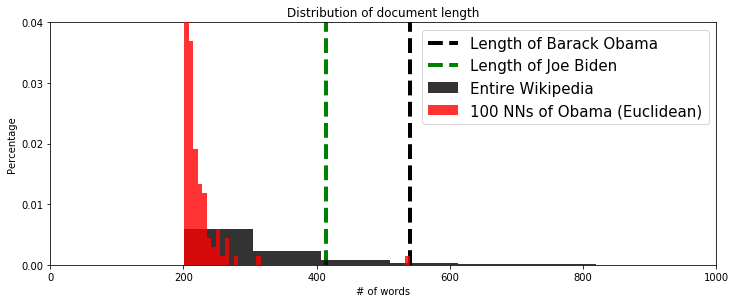

In [73]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Model 3 -  TF IDF with Cosine Similarity

In [74]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = wiki.join(neighbors.set_index('id'))[['name', 'length', 'distance']].sort_values('distance')
print(nearest_neighbors_cosine[:10])

                          name  length  distance
35817             Barack Obama     540  0.000000
24478                Joe Biden     414  0.703139
38376           Samantha Power     310  0.742982
57108   Hillary Rodham Clinton     580  0.758358
38714  Eric Stern (politician)     255  0.770561
46140             Robert Gibbs     257  0.784678
6796               Eric Holder     232  0.788039
44681   Jesse Lee (politician)     216  0.790926
18827             Henry Waxman     279  0.798323
2412           Joe the Plumber     217  0.799466


<Figure size 756x324 with 0 Axes>

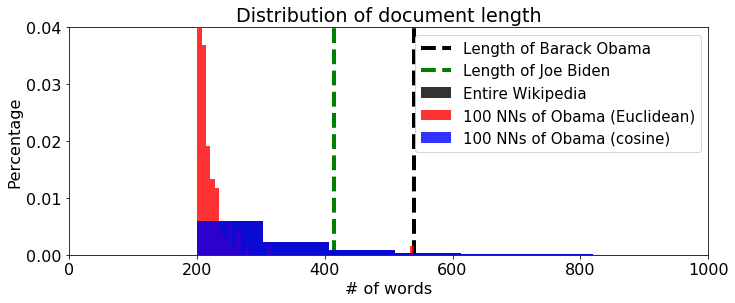

In [75]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [76]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}


df_map_index_to_word = pd.DataFrame(list(map_index_to_word.items()), columns = ['category', 'index'])
df_map_index_to_word.head()

,category,index
0,biennials,522004
1,lb915,116290
2,shatzky,127647
3,woode,174106
4,damfunk,133206


In [78]:
word_indices = [df_map_index_to_word[df_map_index_to_word['category']==word].iloc[0]['index'] for word in tweet.keys()]
tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )  # size = 1x547979
print(tweet_tf_idf.shape)

(1, 547979)


In [85]:
obama_tf_idf = tf_idf[35817]
print(cosine_distances(obama_tf_idf, tweet_tf_idf))

[[0.70591838]]


In [86]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print(distances)


[[0.         0.70313868 0.7429819  0.7583584  0.77056123 0.7846775
  0.78803907 0.79092642 0.7983226  0.79946636]]
